In [59]:
# In this notebook we analyse the convergence of different SDE solvers for the 
# Girsanov reweighting of the ISOKANN problem with optimal control
using Revise
using OptImpSampling, StochasticDiffEq, DiffEqNoiseProcess, Plots
using OptImpSampling: Doublewell, isokann, optcontrol, GirsanovSDE, girsanovsample, statify

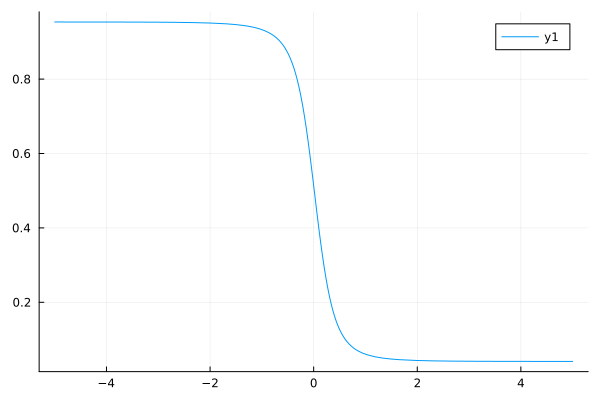

In [18]:

dynamics = Doublewell()
r = isokann(;dynamics);
plot(x->r.model([x])[1])

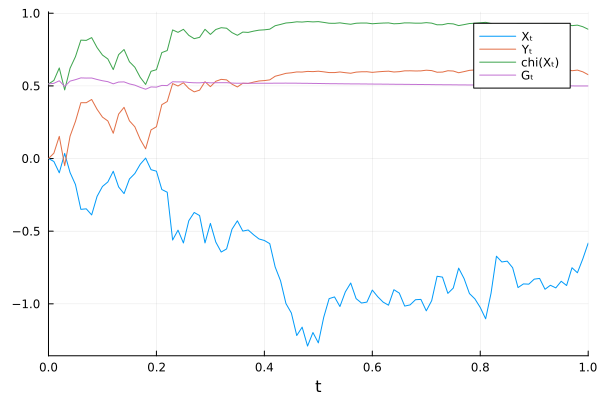

In [94]:

using Random
Random.seed!(0)
sde = OptImpSampling.SDEProblem(dynamics, [0.])        # basic Doublewell SDE
u = optcontrol(statify(r.model), r.S, sde)                # compute the optimal control from the ISOKANN result
s = solve(GirsanovSDE(sde, u), save_noise=true)  # solve the girsanov SDE and save the noise
W = NoiseWrapper(s.W)                            # extract the noise for convergence analysis
plot(s, label=["Xₜ" "Yₜ"])
chis = r.model(s[1,:]')'
ws = @. exp(-s[2,:])
plot!(s.t, [chis chis .* ws], label=["chi(Xₜ)" "Gₜ"])

(alg, dt) = (EM{true}(), 0.010000000000000004)
  0.577755 seconds (1.12 M allocations: 155.524 MiB)
(alg, dt) = (EM{true}(), 0.0026826957952797263)
  0.628621 seconds (1.13 M allocations: 158.083 MiB)
(alg, dt) = (EM{true}(), 0.0007196856730011526)
  0.834948 seconds (1.13 M allocations: 158.652 MiB, 15.68% gc time)
(alg, dt) = (EM{true}(), 0.00019306977288832496)
  0.618020 seconds (1.14 M allocations: 157.440 MiB)
(alg, dt) = (EM{true}(), 5.179474679231213e-5)
  1.495984 seconds (1.25 M allocations: 169.107 MiB)
(alg, dt) = (EM{true}(), 1.389495494373139e-5)
  4.784503 seconds (1.65 M allocations: 210.760 MiB, 2.92% gc time)
(alg, dt) = (EM{true}(), 3.7275937203149398e-6)
 22.396650 seconds (3.11 M allocations: 379.367 MiB)
(alg, dt) = (EM{true}(), 1.0000000000000004e-6)
171.185697 seconds (8.57 M allocations: 978.312 MiB, 0.55% gc time)
(alg, dt) = (LambaEM{true}(), 0.010000000000000004)
  7.178567 seconds (6.57 M allocations: 869.221 MiB)
(alg, dt) = (LambaEM{true}(), 0.00268269579

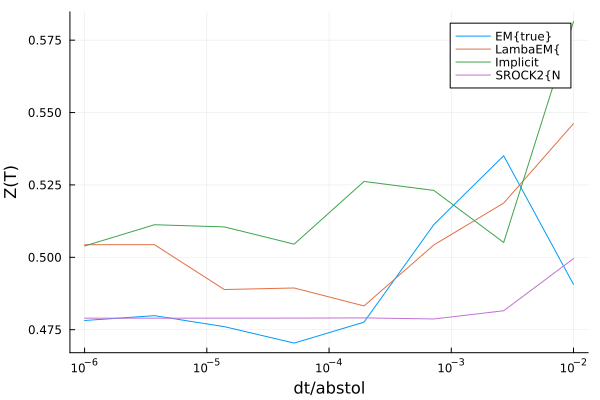

In [107]:
logspace(min, max, n) = reverse(exp.(range(log(min), log(max), n)))

function plot_e_convergence!(;min=1e-6, max=1e-2, n=8, alg=EM())

    dts = logspace(min, max, n)
    
    e = map(dts) do  dt
        cde = GirsanovSDE(OptImpSampling.SDEProblem(Doublewell(), [0.], noise=W, alg=alg, dt=dt, abstol=dt), u)
        @show alg, dt
        @time x,w = girsanovsample(cde, 0.)
        e = r.model(x)[1] * w
    end
    plot!(dts, e, xaxis=:log, label=Base.string(typeof(alg))[1:8])
end

plot()
for alg in [EM(), LambaEM(), ImplicitEM(), SROCK2()]
    plot_e_convergence!(alg=alg)
end
plot!(xlabel="dt/abstol", ylabel="Z(T)")
